In [1]:
from iminuit import Minuit, describe
from probfit import BinnedLH, AddPdf, gen_toy
from probfit.plotting import draw_pdf
import numpy as np
%matplotlib inline

In [2]:
class Interpolate(object):
    def __init__(self, scheme):
        self.scheme = scheme
    def __call__(self, alpha, I0, Iup, Idown):
        if self.scheme == 0:
            return self.PiecewiseLinear(alpha, I0, Iup, Idown)
        elif self.scheme == 1:
            return self.PiecewiseExponential(alpha, I0, Iup, Idown)
                
    def PiecewiseLinear(self, alpha, I0, Iup, Idown):
        if alpha < 0:
            return (1 + alpha*(I0-Idown))
        else:
            return (1 + alpha*(Iup - I0))
    def PiecewiseExponential(self, alpha, I0, Iup, Idown):
        if alpha < 0:
            return pow((Idown / I0),-alpha)
        else:
            return pow((Iup / I0),alpha)

In [3]:
class MinimalFuncCode:
    def __init__(self, arg):
        self.co_varnames = tuple(arg)
        self.co_argcount = len(arg)

    def append(self, varname):
        tmp = list(self.co_varnames)
        tmp.append(varname)
        self.co_varnames = tuple(tmp)
        self.co_argcount = len(self.co_varnames)
        
class FakeFuncCode:
    def __init__(self, f, prmt=None, dock=0, append=None):
        #f can either be tuple or function object
        self.co_varnames = describe(f)
        self.co_argcount = len(self.co_varnames)
        self.co_argcount -= dock
        self.co_varnames = self.co_varnames[dock:]

        if prmt is not None:  #rename parameters from the front
            for i, p in enumerate(prmt):
                self.co_varnames[i] = p

        if isinstance(append, str): append = [append]

        if append is not None:
            old_count = self.co_argcount
            self.co_argcount += len(append)
            self.co_varnames = tuple(
                list(self.co_varnames[:old_count]) +
                append +
                list(self.co_varnames[old_count:]))

In [4]:
class HistogramPdf(object):
    def __init__(self, hy, binedges, xname='x'):
        """
        A histogram PDF. User supplies a template histogram with bin contents and bin
        edges. The histogram does not have to be normalized. The resulting PDF is normalized.
        """
        # Normalize, so the integral is unity
        #yint= hy*(binedges[1:]-binedges[:-1])
        #self.n = yint.sum()
        #print 'initial guess is',self.n
        self.hy= hy.astype(float)#/float(yint.sum())
        self.binedges= binedges
        if len(binedges)!= len(hy)+1:
            raise ValueError('binedges must be exactly one entry more than hy')
        # Only one variable. The PDF shape is fixed
        varnames= [xname]
        self.func_code = MinimalFuncCode(varnames)
        self.func_defaults = None

    def integrate(self, bound, nint_subdiv=0, arg=None):
        # nint_subdiv is irrelevant, ignored.
        # bound usually is smaller than the histogram's bound.
        # Find where they are:
        edges= np.copy(self.binedges)
        [ib0,ib1]= np.digitize([bound[0],bound[1]], edges)
        ib0= max(ib0,0)
        ib1= min(ib1, len(edges)-1)
        edges[ib0-1]= max(edges[ib0-1],bound[0])
        edges[ib1]= min(edges[ib1],bound[1])
        ilo= max(0,ib0-1)
        ihi= ib1+1 if edges[ib1-1]!=edges[ib1] else ib1
        return (self.hy[ilo:ihi-1]*np.diff(edges[ilo:ihi])).sum()

    def __call__(self, *arg):
        x = arg[0]
        [i]= np.digitize([x], self.binedges)
        if i >0 and i<=len(self.hy):
            return self.hy[i-1]
        else:
            return 0.0

In [5]:
class NormedHist:
    def __init__(self, f, norm='N'):
        self.f = f
        if norm in describe(f):
            raise ValueError('%s is already taken pick something else for extname'%extname)
        self.func_code = FakeFuncCode(f,append=norm)
        #print self.func_code.__dict__
        self.func_defaults=None

    def __call__(self, *arg):
        N = arg[-1]
        fval = self.f(arg[0])
        return fval*N

    def integrate(self, bound, nint, *arg):
        N = arg[-1]
        ana = self.f.integrate(bound, nint, arg[:-1])
        return N*ana

In [6]:
class OverallSys:
    def __init__(self, f, OverallSys='NormSys', up=1., down=1., scheme=1.):
        self.f = f
        self.up = up
        self.down = down
        self.scheme = scheme
        if OverallSys in describe(f):
            raise ValueError('%s is already taken pick something else for systematicname'%OverallSys)
        self.func_code = FakeFuncCode(f,append=OverallSys)
        #print self.func_code.__dict__
        self.func_defaults=None

    def __call__(self, *arg):
        fval = self.f(arg[0])
        alpha = arg[-1]
        inter = Interpolate(self.scheme)
        if fval>0:
            return inter(alpha, fval, self.up, self.down)
        else:
            return 0

    def integrate(self, bound, nint, *arg):
        alpha = arg[-1]
        inter = Interpolate(self.scheme)
        mod = inter(alpha, 1., self.up, self.down)
        ana = self.f.integrate(bound, nint, arg[:-1])
        return mod*ana

# definining a sample

In [7]:
bound = (0, 10)
np.random.seed(0)
bkg = gen_toy(lambda x : x**2, 100, bound=bound) # a parabola background
sig= np.random.randn(50)+5  # a Gaussian signal

In [8]:
hsig,be= np.histogram(sig, bins=10, range=bound)
hbkg,be= np.histogram(bkg, bins=be, range=bound)

## Test that the histograms look ok...

In [9]:
print 'signal is ',hsig
print 'background is', hbkg

signal is  [ 0  0  0  7 10 19 14  0  0  0]
background is [ 0  1  3  2 11 10 10 14 28 21]


### Create a Model
The signal pdf has a normlisation. The Background has a OveralSystematic.

In [10]:
psig= HistogramPdf(hsig,be)
pbkg= HistogramPdf(hbkg,be)
epsig= NormedHist(psig, norm='mu')
epbkg= OverallSys(pbkg, OverallSys='JES', up=1.2, down=.8, scheme=1.)
pdf= AddPdf(epbkg,epsig)

Verify which parameters need to be supplied to create some data

In [11]:
describe(pdf)

['x', 'JES', 'mu']

Generate some data from the model and check that it looks ok in histogram form. 

In [28]:
data = gen_toy(lambda x : pdf(x,1.,1.), 150,(0,10))
data_hist,bins = np.histogram(data)
print 'data is',data_hist

data is [ 2  0 15 15 19 25 33 25 15  1]


# Define Cost Function. 
Initially, we set mu to be zero and draw the data with the background only model. 

0.0


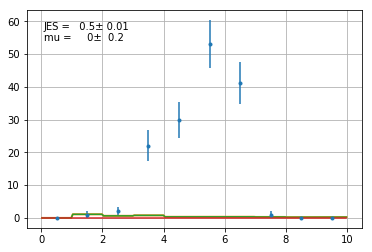

In [31]:
blh= BinnedLH(pdf, data, bins=10, bound=bound, extended=True)
m= Minuit(blh, mu=0., JES=0.5, error_mu=.20, error_JES=.01, limit_JES=(-2,2))
blh.draw(m, parts=True)
print m.values['mu']

### Minimize! 
and draw the fitted model.

/Users/vince/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: LogWarning: x is really small return 0
  """Entry point for launching an IPython kernel.


FCN = 37.552165395 
 TOTAL NCALL = 58 
 NCALLS = 58 
 
 
 EDM = 8.93809515525e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,JES,-2,0.0567131,0,0,-2.0,2.0,
2,mu,2.50644,0.241285,0,0,,,


2.50644358854


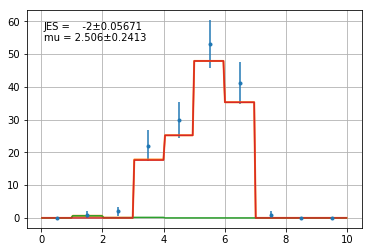

In [32]:
m.migrad()
blh.draw(m, parts=True)
print m.values['mu']